In [4]:
# SETUP
import matplotlib.pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay
import numpy as np
import json
import requests
import pandas as pd

# METRICS TABLE
# Define custom decorator to automatically calculate metric based on key
metrics = {}
metric = lambda f: metrics.setdefault(f.__name__, f)

@metric
def ap(results, relevant):
    """Average Precision"""
    precision_values = []
    precision_values = [
        len([
            doc 
            for doc in results[:idx]
            if doc in relevant
        ]) / idx 
        for idx, _ in enumerate(results, start=1)
    ]

    return sum(precision_values)/max(len(precision_values),1)

@metric
def p10(results, relevant, n=10):
    """Precision at N"""
    return len([doc for doc in results[:n] if doc in relevant])/n

# Define metrics to be calculated
evaluation_metrics = {
    'ap': 'Average Precision',
    'p10': 'Precision at 10 (P@10)'
}

class Evaluate:
    
    def __init__(self, results, relevant):
        self.results = results
        self.relevant = relevant
        # then remove
        print('Results: ', results)
        print('Relevant: ', relevant)
        
    def calculate_metric(self,metric):
        return metrics[metric](self.results, self.relevant)
    
    def export_metrics(self, file_path):
        df = pd.DataFrame([['Metric', 'Value']] + 
                          
            [[metric, self.calculate_metric(metric)] for metric in evaluation_metrics.keys()])

        with open(f'{file_path}/evaluation.tex', 'w+') as f:
            f.write(df.to_latex())
            
    def export_average_precision(self, file_path):
        average_precision = self.calculate_metric('ap')
        with open(f'{file_path}/average_precision.txt', 'w+') as f:
            f.write(str(average_precision))
            
    def precision_recall(self):
        
        if not self.results: return
        
        # Get precision and recall values
        precision_values = [
            len([
                doc 
                for doc in self.results[:idx]
                if doc in self.relevant
            ]) / idx 
            for idx, _ in enumerate(self.results, start=1)
        ]
        
        recall_values = [
            len([
                doc for doc in self.results[:idx]
                if doc in self.relevant
            ]) / len(self.relevant)
            for idx, _ in enumerate(self.results, start=1)
        ]
        
        precision_recall_match = {k: v for k,v in zip(recall_values, precision_values)}
        
        recall_values.extend([step for step in np.arange(0.1, 1.1, 0.1) if step not in recall_values])
        recall_values = sorted(set(recall_values))
        
        # Extend matching dict to include these new intermediate steps
        for idx, step in enumerate(recall_values):
            if step not in precision_recall_match:
                if recall_values[idx-1] in precision_recall_match:
                    precision_recall_match[step] = precision_recall_match[recall_values[idx-1]]
                else:
                    precision_recall_match[step] = precision_recall_match[recall_values[idx+1]]

        disp = PrecisionRecallDisplay([precision_recall_match.get(r) for r in recall_values], recall_values)
        disp.plot()
        plt.savefig('precision_recall.pdf')





In [21]:
queries = {
    "basic1": "http://localhost:8983/solr/simple_conversations/select?debug.explain.structured=true&debugQuery=true&defType=lucene&fl=*%2C%20score%2C%20%5Bchild%5D&indent=true&q.op=AND&q=genres%3Aaction%20transcript%3Akill&rows=100&useParams=",
    "basic2": "http://localhost:8983/solr/complex_conversations/select?debug.explain.structured=true&debugQuery=true&defType=lucene&fl=*%2C%20score%2C%20%5Bchild%5D&indent=true&q.op=AND&q=genres%3Aaction%20transcript%3Akill&rows=100&useParams=",
    "complex1":"http://localhost:8983/solr/simple_conversations/select?debug.explain.structured=true&debugQuery=true&defType=lucene&fl=*%2C%20score%2C%20%5Bchild%5D&indent=true&q.op=AND&q=genres%3Aaction%20transcript%3A(kill*)&rows=100&useParams=",
    "complex2":"http://localhost:8983/solr/complex_conversations/select?debug.explain.structured=true&debugQuery=true&defType=lucene&fl=*%2C%20score%2C%20%5Bchild%5D&indent=true&q.op=AND&q=genres%3Aaction%20transcript%3A(kill*)&rows=100&useParams="
}

QRELS_FILE = "./q1/qrels.txt"
folder = "./q1/"

In [23]:
queries = {
    "basic1": "http://localhost:8983/solr/simple_conversations/select?defType=lucene&fl=*%2C%20score%2C%20%5Bchild%5D&indent=true&q.op=AND&q=transcript%3A%22what%20you%20are%20doing%22&rows=16&useParams=",
    "basic2": "http://localhost:8983/solr/complex_conversations/select?defType=lucene&fl=*%2C%20score%2C%20%5Bchild%5D&indent=true&q.op=AND&q=transcript%3A%22what%20you%20are%20doing%22&rows=16&useParams=",
    "complex1":"http://localhost:8983/solr/simple_conversations/select?defType=lucene&fl=*%2C%20score%2C%20%5Bchild%5D&indent=true&q.op=AND&q=transcript%3A%22what%20you%20are%20doing%22~2&rows=16&useParams=",
    "complex2":"http://localhost:8983/solr/complex_conversations/select?defType=lucene&fl=*%2C%20score%2C%20%5Bchild%5D&indent=true&q.op=AND&q=transcript%3A%22what%20you%20are%20doing%22~2&rows=16&useParams="
}



QRELS_FILE = "./q2/qrels.txt"
folder = "./q2/"


In [27]:
queries = {
    "basic1": "http://localhost:8983/solr/simple_conversations/select?defType=edismax&fl=*%2C%20score%2C%20%5Bchild%5D&indent=true&q.op=AND&q=movie%3A%22a%20nightmare%20on%20elm%20street%22%20(transcript%3AFreddy%20OR%20transcript%3AKrueger)&rows=50&useParams=",
    "basic2": "http://localhost:8983/solr/complex_conversations/select?debug.explain.structured=false&debugQuery=false&defType=edismax&fl=*%2C%20score%2C%20%5Bchild%5D&indent=true&q.op=AND&q=movie%3A%22a%20nightmare%20on%20elm%20street%22%20(transcript%3AFreddy%20OR%20transcript%3AKrueger)&rows=100&useParams=",
    "complex1": "http://localhost:8983/solr/simple_conversations/select?bq=year%3A1989&defType=edismax&fl=*%2C%20score%2C%20%5Bchild%5D&indent=true&q.op=AND&q=movie%3A%22a%20nightmare%20on%20elm%20street%22%20(transcript%3AFred*%20OR%20transcript%3AKrueger)%5E5&rows=50&useParams=",
    "complex2": "http://localhost:8983/solr/complex_conversations/select?bq=year%3A1989&debug.explain.structured=false&debugQuery=false&defType=edismax&fl=*%2C%20score%2C%20%5Bchild%5D&indent=true&q.op=AND&q=movie%3A%22a%20nightmare%20on%20elm%20street%22%20(transcript%3AFred*%20OR%20transcript%3AKrueger)%5E5&rows=100&useParams="
}

QRELS_FILE = "./q3/qrels.txt"
folder = "./q3/"

Results:  ['4563', '4653', '4875', '4816', '4788', '4804', '4544', '4627', '4617', '4570']
Relevant:  ['4762', '4788', '4801', '4804', '4807', '4816', '4875', '4885', '4894']
Results:  ['4653', '4563', '4816', '4762', '4875', '4807', '4788', '4804', '4544', '4894', '4627', '4617', '4570']
Relevant:  ['4762', '4788', '4801', '4804', '4807', '4816', '4875', '4885', '4894']
Results:  ['4875', '4816', '4788', '4804', '4885', '4544', '4563', '4570', '4603', '4617', '4627', '4653']
Relevant:  ['4762', '4788', '4801', '4804', '4807', '4816', '4875', '4885', '4894']
Results:  ['4816', '4762', '4875', '4807', '4788', '4804', '4894', '4885', '4544', '4563', '4570', '4603', '4617', '4627', '4653']
Relevant:  ['4762', '4788', '4801', '4804', '4807', '4816', '4875', '4885', '4894']
1 & NR & NR & R & R\\
2 & NR & NR & R & R\\
3 & R & R & R & R\\
4 & R & R & R & R\\
5 & R & R & R & R\\
6 & R & R & NR & R\\
7 & NR & R & NR & R\\
8 & NR & R & NR & R\\
9 & NR & NR & NR & NR\\
10 & NR & R & NR & NR\\


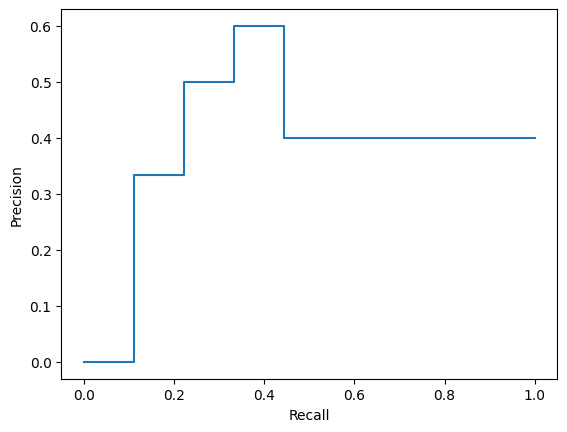

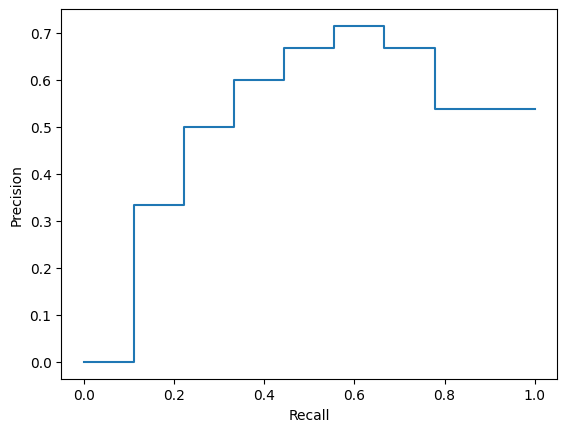

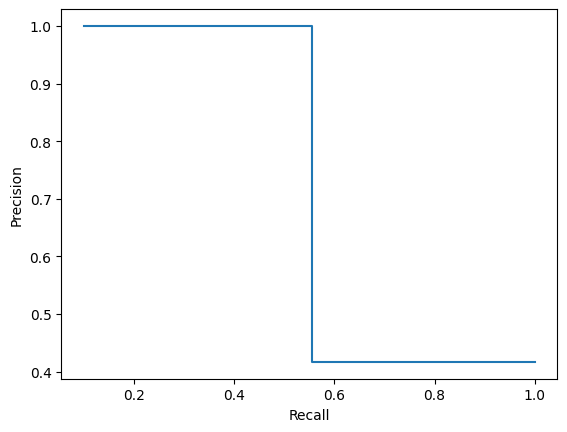

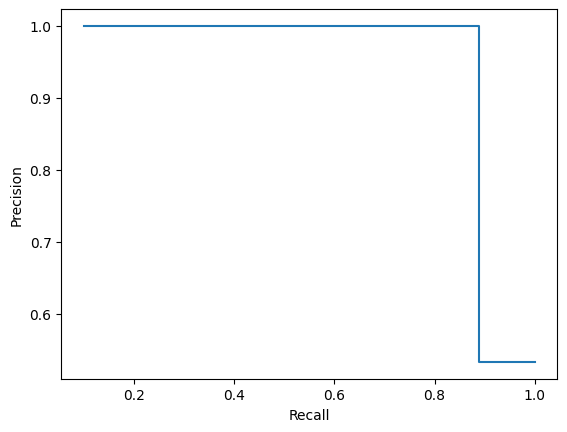

In [28]:
import os

# Read qrels to extract relevant documents
relevant = list(map(lambda el: el.strip(), open(QRELS_FILE).readlines()))

results_dict = {}
resultGraphs = []

for query, url in queries.items():
    results = requests.get(url).json()['response']['docs']
    
    results = [x['id'] for x in results]
    results_dict[query] = results
    
    evaluation = Evaluate(results, relevant)
    path = f'{folder}{query}'
    
    if not os.path.exists(path):
        os.makedirs(path)
        
    evaluation.export_metrics(path)
    resultGraphs.append(evaluation.precision_recall())
    evaluation.export_average_precision(path)
    
for i in range(10):
    basic1_results = ('R' if results_dict['basic1'][i] in relevant else 'NR') if results_dict['basic1'] and i < len(results_dict['basic1']) else 'N/A'
    basic2_results = ('R' if results_dict['basic2'][i] in relevant else 'NR') if results_dict['basic2'] and i < len(results_dict['basic2']) else 'N/A'
    complex1_results = ('R' if results_dict['complex1'][i] in relevant else 'NR') if results_dict['complex1'] and i < len(results_dict['complex1']) else 'N/A'
    complex2_results = ('R' if results_dict['complex2'][i] in relevant else 'NR') if results_dict['complex2'] and i < len(results_dict['complex2']) else 'N/A'
    
    print(f'{i+1} & {basic1_results} & {basic2_results} & {complex1_results} & {complex2_results}\\\\')
